### Registration

In [156]:
import open3d as o3d
import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt
from math import *

In [97]:
print("Load a ply point cloud, print it, and render it")
source = o3d.io.read_point_cloud("data/fragment_001.ply")
target = o3d.io.read_point_cloud("data/fragment_000.ply")

Load a ply point cloud, print it, and render it


In [98]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)

    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

In [99]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

In [100]:
def prepare_dataset(voxel_size):
    print(":: Load two point clouds and disturb initial pose.")
    # source = o3d.io.read_point_cloud("data/owl_sampled.ply")
    # target = o3d.io.read_point_cloud("data/owl_target.ply")
    source = o3d.io.read_point_cloud("data/fragment_001.ply")
    target = o3d.io.read_point_cloud("data/fragment_000.ply")
    # trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
    #                          [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    # source.transform(trans_init)
    # draw_registration_result(source, target, np.identity(4))

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

In [101]:
# voxel_size = 5  # For owls point cloud
voxel_size = 0.05
source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(
    voxel_size)

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.


In [102]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

In [103]:
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print(result_ransac)
draw_registration_result(source_down, target_down, result_ransac.transformation)

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
RegistrationResult with fitness=8.459231e-01, inlier_rmse=3.075001e-02, and correspondence_set size of 4513
Access transformation to get result.


In [104]:
def refine_registration(source, target, source_fpfh, target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.4
    print(":: Point-to-plane ICP registration is applied on original point")
    print("   clouds to refine the alignment. This time we use a strict")
    print("   distance threshold %.3f." % distance_threshold)

    radius_normal = voxel_size * 2
    source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return result


In [105]:
result_icp = refine_registration(source, target, source_fpfh, target_fpfh,
                                 voxel_size)
print(result_icp)
draw_registration_result(source, target, result_icp.transformation)

:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.020.
RegistrationResult with fitness=7.868372e-01, inlier_rmse=6.321583e-03, and correspondence_set size of 163467
Access transformation to get result.


In [106]:
print(result_icp.transformation)

[[ 0.97290931 -0.07350814  0.21918949  0.15265733]
 [ 0.01020337  0.96083333  0.27693899 -0.65713764]
 [-0.23096183 -0.26720005  0.93555372  0.23755676]
 [ 0.          0.          0.          1.        ]]


### Analysing the quality of the registration

In [174]:
draw_registration_result(source, target, np.identity(4))
# o3d.visualization.draw_geometries([source, target])

In [175]:
source_t = copy.deepcopy(source)
source_t.transform(result_icp.transformation)

source_temp = copy.deepcopy(source)
source_temp.paint_uniform_color([1, 0.706, 0])

PointCloud with 207752 points.

In [176]:
# The origin of the target cloud is the global origin
# The origin of the source cloud is the global origin transformed by the transformation
# display the source and target point clouds with their origins
target_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.6, origin=[0, 0, 0])
source_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.6, origin=[0, 0, 0])
source_origin.transform(result_icp.transformation)


TriangleMesh with 1134 points and 2240 triangles.

In [177]:
o3d.visualization.draw_geometries([source_t, source_temp, target, source_origin, target_origin])

In [178]:
def project_pcd_to_depth(pcd, camera_pose, scale = (720, 720), depth_max=10.0, depth_scale=15.0, focal_dist=500.0):
    width, height = scale  
    pcd_t = o3d.t.geometry.PointCloud.from_legacy(pcd)
    intrinsics =o3d.core.Tensor([[focal_dist, 0     , width * 0.5], 
                                [0     , focal_dist, height * 0.5],
                                [0     , 0     , 1]])
    extrinsics = o3d.core.Tensor(camera_pose)
    depth_reproj = pcd_t.project_to_depth_image(width,
                                            height,
                                            intrinsics,
                                            extrinsics,
                                            depth_scale=depth_scale,
                                            depth_max=depth_max)
      
    depth_mat = np.asarray(depth_reproj.to_legacy())
    plt.imshow(depth_mat)
    plt.show()
    
    return depth_mat


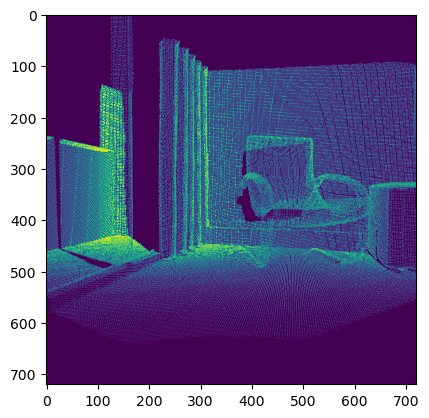

In [179]:
I21 =project_pcd_to_depth(source_t, np.identity(4))

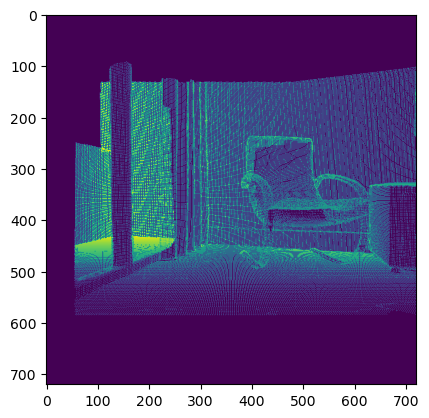

In [180]:
I11 = project_pcd_to_depth(target, np.identity(4))

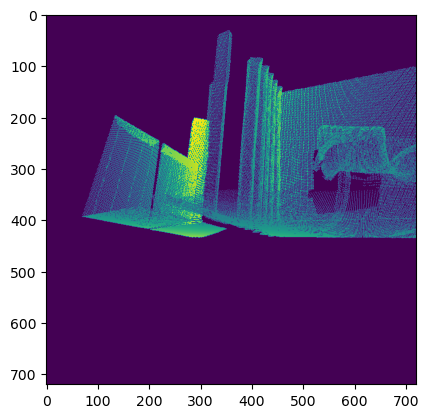

In [181]:
I22 = project_pcd_to_depth(source_t, result_icp.transformation)

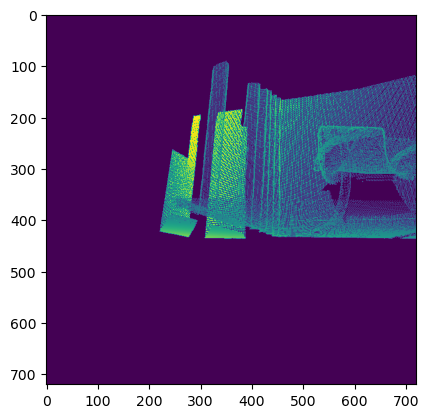

In [182]:
I12 = project_pcd_to_depth(target, result_icp.transformation)

In [183]:
print(I11)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [184]:
# # Compare I11 and I21
# # Rescale arrays to a single dimension vector
# I11 = I11.flatten()
# I21 = I21.flatten()

# if I11.shape[0] != I21.shape[0]:
#     print("Error: I11 and I21 have different shapes")

In [185]:
# p = np.zeros_like(I11)

# def CDF(x):
#     return 1/2 * (1 + erf(x/sqrt(2)))

# def p_calc(delJ, sigma):
#     p = 1 - (CDF(delJ/sigma) - CDF(-delJ/sigma))
#     return p

# sigma = 0.01

# for i in range(I11.shape[0]):
#     if I11[i] == 0 and I21[i] == 0:
#         p[i] = 0
#     elif I11[i] == 0 or I21[i] != 0:
#         p[i] = p_calc(2*sigma, sigma)
#     elif I11[i] != 0 or I21[i] != 0:
#         p[i] = p_calc(abs(I11[i] - I21[i]), sigma)
#     # else:
#     #     p[i] = 0

In [186]:
# # Find M which is the number of non-zero elements in p
# M = np.count_nonzero(p)
# print(M)

In [187]:
# # Perform opinion pooling on p
# # Find the mean of p
# # mean_p = np.sum(p)/M
# print(mean_p)

In [200]:
def get_p(I11, I12, I21, I22, sigma = 0.01):
    def CDF(x):
        return 1/2 * (1 + erf(x/sqrt(2)))

    def p_calc(delJ, sigma):
        p = (CDF(delJ/sigma) - CDF(-delJ/sigma))
        return p
    
    I_pair = [(I11, I21),(I22, I12)]
    net_p = []

    for i,pair in enumerate(I_pair):
        I1 = pair[0].flatten()
        I2 = pair[1].flatten()
        p = np.zeros_like(I1)
        for i in range(I1.shape[0]):
            if I1[i] == 0 and I2[i] == 0:
                p[i] = 0
            elif I1[i] == 0 or I2[i] != 0:
                p[i] = p_calc(2*sigma, sigma)
            elif I1[i] != 0 or I2[i] != 0:
                p[i] = p_calc(abs(I1[i] - I2[i]), sigma)
        net_p.extend(p.tolist())

    net_p = np.array(net_p)
    net_p = net_p.flatten()
    M = np.count_nonzero(net_p)
    match_p = np.sum(net_p)/M

    return match_p

In [201]:
net_p = get_p(I11, I12, I21, I22)
print(net_p)

0.9711778971517674


### Pipeline Integration

In [1]:
from quality_utils import *
import open3d as o3d
import numpy as np
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
target = o3d.io.read_point_cloud("data/fragment_000.ply")
source = o3d.io.read_point_cloud("data/fragment_001.ply")

In [3]:
voxel_size = 0.05

In [4]:
# 1. Downsample the point clouds and get the FPFH features
source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)

:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.


In [5]:
# Coarse registration
global_registration_result = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.


In [6]:
# Refine registration
refine_registration_result = refine_registration(source, target, source_fpfh, target_fpfh, voxel_size, global_registration_result.transformation)

:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.020.


In [7]:
# Visualize registration result
draw_registration_result(source, target, refine_registration_result.transformation)

In [8]:
# Find origins
source_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3, origin=[0, 0, 0])
target_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.6, origin=[0, 0, 0])

# Transform the source origin
source_origin.transform(refine_registration_result.transformation)

# Visualize the point clouds and their origins
source_copy = copy.deepcopy(source) 
source_copy.transform(refine_registration_result.transformation)
o3d.visualization.draw_geometries([source_copy, target, source_origin, target_origin])

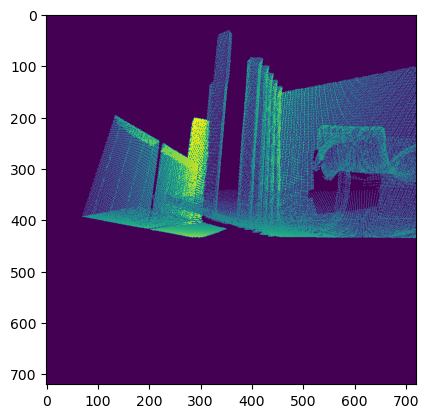

In [10]:
T = refine_registration_result.transformation
I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, T, save=True)

In [11]:
p = get_p(I11, I12, I21, I22)
print(p)

0.0455002635717392
